<h1> Рекомендация тарифов </h1>
 
**Описание проекта:**

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра». В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы.

**Цель проекта:**

Построить модель для задачи классификации, которая выберет подходящий тариф.

**Ход исследования:**

Первым делом получу данные о поведении клиентов из файла `/datasets/users_behavior.csv` и изучу общую информацию.

Так как предобработка данных уже была проведена в предыдущем проекте, сразу перейду к разделению исходных данных на обучающую, валидационную и тестовую выборки. 

После я исследую качество таких моделей как `Decision Tree`, `Random Forest` и `Logistic Regression`, меняя их гиперпараметры. Сравню их и выберу лучшую. 

Затем проверю качество модели на тестовой выборке, а также проверю модели на вменяемость.

Таким образом, моё исследование пройдёт в 6 этапов:
1. [Загрузка и обзор данных](#1)
2. [Разбиение данных на выборки](#2)
3. [Исследование моделей](#3)
4. [Проверка модели на тестовой выборке](#4)
5. [Проверка модели на адекватность](#5)
6. [Вывод](#6)

<a id='1'></a>

<h2> Обзор данных

Импортируем необходимые библиотеки для будущей работы. Считаем данные из csv-файла в переменную df и изучим их.

Путь к файлу: `/datasets/users_behavior.csv`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix

In [2]:
try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('/datasets/users_behavior.csv')

Длина датасета: 3214
Размер датасета: (3214, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


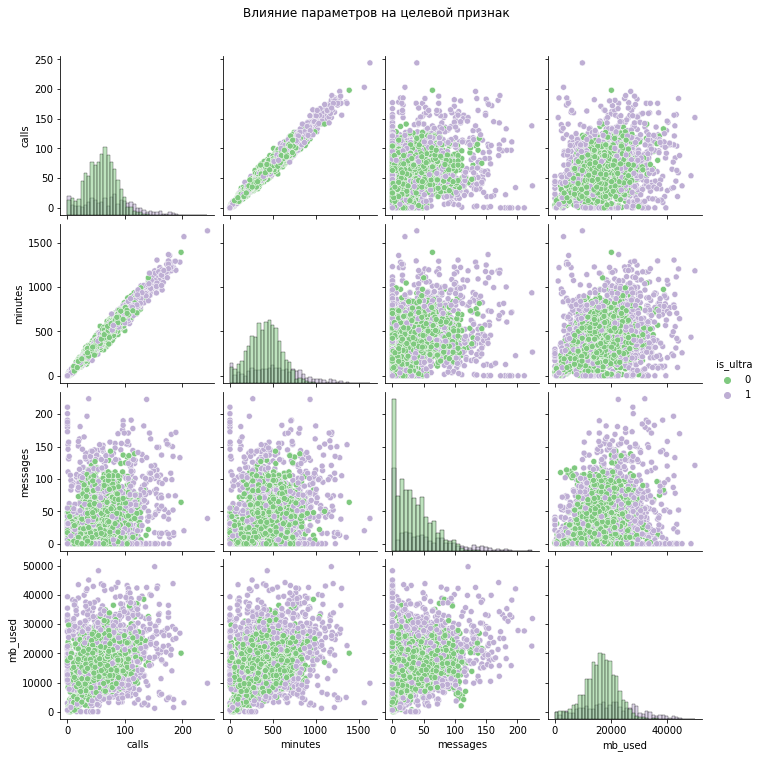

In [3]:
print('Длина датасета:', len(df))
print('Размер датасета:', df.shape, '\n')

df.info()
display(df.head())

corr_matrix = df.corr()
display(corr_matrix.style.background_gradient(cmap='coolwarm'))

corr_plot = sns.pairplot(df, hue='is_ultra', diag_kind="hist", palette = 'Accent')
corr_plot.fig.suptitle('Влияние параметров на целевой признак', y=1.05);

<h3> Вывод

- В датасете 3214 объектов и 5 признаков
- Целевой признак `is_ultra` — категориальный, соответственно, мы будем решать задачу классификации
- Данные о количестве звонков и их суммарной длительности в минутах имеют довольно высокую корреляцию, что может негативно сказаться на модели машинного обучения 

<a id='2'></a>

<h2> Выборки

Объявим две переменные:

- сохраним в `features` признаки
- сохраним в `target` целевой признак

In [4]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

Разделим данные на обучающую, валидационную и тестовую выборки.

In [5]:
# обучающая и (тестовая и валидационная) выборки
(features_train, features_test,
 target_train, target_test) = train_test_split(features, target, 
                                               test_size = 0.4, random_state = 12345)

# валидационная и тестовая выборки 
(features_valid, features_test,
 target_valid, target_test) = train_test_split(features_test, target_test, 
                                               test_size = 0.5, random_state = 12345)

In [6]:
print(features_train.shape,
      features_valid.shape,
      features_test.shape)
print(target_train.shape, 
      target_valid.shape, 
      target_test.shape)

(1928, 4) (643, 4) (643, 4)
(1928,) (643,) (643,)


Размеры тестового и валидационного наборов обычно равны, поэтому исходные данные мы разбили в соотношении 3:1:1.

<a id='3'></a>

<h2> Исследование моделей

Рассмотрим несколько моделей обучения — Decision Tree, Random Forest и Logistic Regression. Исследуем их качества, меняя гиперпараметры. Посмотрим, сколько времени на обучение занимает каждая модель.

Создадим функцию для расчёта accuracy.

In [7]:
def show_accuracy_score(model):
    predictions_valid = model.predict(features_valid)
    return accuracy_score(predictions_valid, target_valid)

<h3>Decision Tree

In [8]:
%%time

dt_accuracy = 0
dt_depth = 0
for depth in range(1,15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    accuracy = show_accuracy_score(model)
    print(f'max_depth = {depth}:', accuracy)
    if accuracy > dt_accuracy:
        dt_accuracy = accuracy
        dt_depth = depth

max_depth = 1: 0.7542768273716952
max_depth = 2: 0.7822706065318819
max_depth = 3: 0.7853810264385692
max_depth = 4: 0.7791601866251944
max_depth = 5: 0.7791601866251944
max_depth = 6: 0.7838258164852255
max_depth = 7: 0.7822706065318819
max_depth = 8: 0.7791601866251944
max_depth = 9: 0.7822706065318819
max_depth = 10: 0.7744945567651633
max_depth = 11: 0.7620528771384136
max_depth = 12: 0.7620528771384136
max_depth = 13: 0.7558320373250389
max_depth = 14: 0.7589424572317263
CPU times: user 96 ms, sys: 4.33 ms, total: 100 ms
Wall time: 97.1 ms


<h3> Random Forest

In [9]:
%%time

rf_accuracy = 0
rf_depth = 0
rf_est = 0
for est in range(1,61,10):
    for depth in range(1,15):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        accuracy = show_accuracy_score(model)
        if accuracy > rf_accuracy:
            rf_accuracy = accuracy
            rf_depth = depth
            rf_est = est

CPU times: user 5.98 s, sys: 25.9 ms, total: 6 s
Wall time: 6.02 s


<h3> Logistic Regression

In [10]:
%%time

lr_model = LogisticRegression(random_state = 12345)
lr_model.fit(features_train, target_train)
lr_accuracy = show_accuracy_score(lr_model)

CPU times: user 24 ms, sys: 3.81 ms, total: 27.8 ms
Wall time: 30.9 ms


<h3> Сравнение

Сравним значения `accuracy` каждой модели.

In [11]:
pd.DataFrame(index=['Decision Tree', 'Random Forest', 'Logistic Regression'],
                  columns=['accuracy', 'max_depth', 'n_estimators'], 
                  data=[[dt_accuracy, dt_depth, np.NaN], 
                        [rf_accuracy, rf_depth, rf_est], 
                        [lr_accuracy, np.NaN, np.NaN]])

,accuracy,max_depth,n_estimators
Decision Tree,0.785381,3.0,NaN
Random Forest,0.807154,8.0,41.0
Logistic Regression,0.710731,NaN,NaN


<h3> Вывод

- Самая высокая скорость работы у логистической регрессии, а самая низкая — у случайного леса
- Лучшее значение `accuracy = 0.807154` показала модель случайного леса с гиперпараметрами `max_depth = 8` и `n_estimators = 41`
- Для дальнейшей работы выберем модель случайного леса

<a id='4'></a>

<h2> Проверка модели на тестовой выборке

Проверим качество модели случайного леса на тестовой выборке.

In [12]:
model = RandomForestClassifier(random_state=12345, max_depth=8, n_estimators=41)
model.fit(features_train, target_train)
model.score(features_test, target_test)

0.7978227060653188

На тестовой выборке модель показывает `accuracy = 0.7978227060653188`, что чуть меньше валидационной, значит переобучение отсутствует.

<a id='5'></a>

<h2> Проверка модели на адекватность

Для проверки адекватности модели машинного обучения используем `DummyClassifier` — классификатор, который делает прогнозы с использованием простых правил и не генерирует никаких ценных сведений о данных. В гиперпараметрах укажем значение `strategy="most_frequent"` — оно всегда предсказывает наиболее часто встречающуюся метку в обучающем наборе.

In [13]:
dc_model = DummyClassifier(random_state=12345, strategy="most_frequent")
dc_model.fit(features_train, target_train)
dc_model.score(features_test, target_test)

0.6842923794712286

У `DummyClassifier` значение `accuracy = 0.6842923794712286` ниже, чем у модели случайного леса, следовательно мы можем назвать модель адекватной.

Построим Confusion Matrix, чтобы детально рассмотреть где модель совершает ошибки.

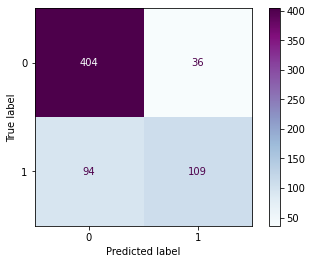

In [14]:
cm_model = RandomForestClassifier(random_state=12345, max_depth=8, n_estimators=41)
cm_model.fit(features_train, target_train)
plot_confusion_matrix(cm_model, features_test, target_test, cmap='BuPu');

Прогноз совпал с реальностью:
- В 404 случаях результат оказался положительный, как и было предсказано ML-моделью
- В 109 случаях результат оказался отрицательный, как и было предсказано ML-моделью

Прогноз не совпал с реальностью:
- В 94 случаях модель предсказала отрицательный результат, но на самом деле он положительный
- В 36 случаях модель предсказала положительный результат, но на самом деле он отрицательный

<a id='6'></a>

<h2> Вывод

<h3> Цель проекта

Построить модель для задачи классификации, которая выберет подходящий тариф.

<h3> Исходные данные

- `сalls` — количество звонков
- `minutes` — суммарная длительность звонков в минутах
- `messages` — количество sms-сообщений
- `mb_used` — израсходованный интернет-трафик в Мб
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

<h3> Выводы

- В данных присутствует высокая корреляция между `calls` и `minutes`
- После исследования таких моделей как `Decision Tree`, `Random Forest` и `Logistic Regression` мы выявили самую выгодную модель — `Random Forest`, с гиперпараметрами `max_depth = 8` и `n_estimators = 41`, которые дают `accuracy = 0.807154`
- Проверка модели на тестовой выборке показала хороший результат с `accuracy = 0.7978227060653188`
- Проверка модели на вменяемость показала, что модель эффективна